In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import hashlib

import os
from glob import glob


import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.feature import local_binary_pattern
from sklearn.svm import LinearSVC


In [2]:
class ImageProcessor:
    def __init__(self, file):
        self.file = file
        self.image = cv2.imread(file)
        self.img_shape = self.image.shape
        self.gray_img = self.changechannel_BGR2GRAY()
        self.lbp = None
        self.hist = None
        self.img_label = None
        self.name = f"Image_cat_{self.img_label}_{file.split('/')[-1]}"
        
    def changechannel_BGR2GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    
    def resize_image(self, size=(160, 160)):
        self.image = cv2.resize(self.image, size)
    
    def set_img_feature(self, lbp):
        self.lbp = lbp
    
    def set_img_hist(self, hist):
        self.hist = hist
        
    def set_img_label(self, label):
        self.img_label = label
        self.update_img_name()
        
    def update_img_name(self):
        self.name = f"Image_cat_{self.img_label}_{self.file.split('/')[-1]}"
        
    def get_img_feature(self):
        return self.lbp
    
    def get_gray_img(self):
        return self.gray_img
    
    def get_image(self):
        return self.image
    
    def get_img_shape(self):
        return self.img_shape
    
    def get_img_hist(self):
        return self.hist
    
    def get_img_label(self):
        return self.img_label
    
    def display_img(self):
        plt.imshow(self.image)
        plt.show()
    
    def display_gray_img(self):
        plt.imshow(self.gray_img)
        plt.show()
        

In [3]:
class DataHandler:
    def __init__(self, path):
        self.path = "dataset/archive/images/train/"
        self.img_paths = {}
        self.global_subdir = []
        self.get_all_image_paths()
    
    def build_file_paths(self, files, path, subdir):
        new_files = []
        for file in files:
            new_files.append(path+'/'+file)
    
        return new_files
    
    def get_all_image_paths(self):
        counter = 0
        for path, subdir, file in os.walk(self.path):
            if counter == 0:
                self.global_subdir = subdir
            else:
                expression = self.global_subdir[counter-1]
                file = self.build_file_paths(file, path, expression)
                self.img_paths[expression] = file
            counter += 1
    
    def get_first_img(self, expr):
        return self.img_paths[expr][0]
    
    def get_first_n_imgs(self, expr, num_images=5):
        return self.img_paths[expr][:num_images]
    
    def get_first_n_imgs_multiexpr(self, expr_list, num_images=5):
        img_paths = {}
        for expr in expr_list:
            img_paths[expr] = self.img_paths[expr][:num_images]
        return img_paths
    
    def get_all_imgs(self):
        return self.img_paths

In [4]:
class FeatureExtraction:
    def __init__(self, datahandler, radius = 1, n_points = 8, num_images = 5):
        self.img_processors = []
        self.datahandler = datahandler
        self.expressions = datahandler.global_subdir
        self.num_images = num_images
        
        self.radius = radius
        self.n_points = n_points * self.radius
        
        self.extract_features()
        
    def get_img_processors(self):
        return self.img_processors
        
    def extract_features(self):
        img_paths = self.datahandler.get_first_n_imgs_multiexpr(self.expressions, self.num_images)
        
        for expr in img_paths.keys():
            for path in img_paths[expr]:
                img_processor = ImageProcessor(path)
                img_processor.set_img_label(expr)
                self.img_processors.append(img_processor) 
        
        for img_processor in self.img_processors:
            lbp = local_binary_pattern(img_processor.get_gray_img(), self.n_points, self.radius, method='uniform')
            img_processor.set_img_feature(lbp)
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.n_points + 2), range=(0, self.n_points + 2))
            hist = hist.astype('float')
            hist /= (hist.sum() + 1e-7)
            hist = hist[:-1]
            img_processor.set_img_hist(hist)
            
    def extract_singleimg_features(self, image):
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        resized_image = cv2.resize(gray, (48, 48))
        
        lbp = local_binary_pattern(resized_image, self.n_points, self.radius, method="uniform")
        
        lbp = np.expand_dims(lbp, axis=-1)
        
        return lbp
        

In [5]:
class Model:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.data = []
        self.labels = []
        self.get_data_and_labels()
        
    def get_data_and_labels(self):
        img_processor_list = self.feature_extractor.get_img_processors()
        for img_processor in img_processor_list:
            self.data.append(img_processor.get_img_hist())
            self.labels.append(img_processor.get_img_label())
        
        # split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.data, self.labels, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def get_img_data_labels4CNN(self):
        img_processor_list = self.feature_extractor.get_img_processors()
        img_list = []
        
        for img_processor in img_processor_list:
            lbp = img_processor.lbp
            lbp = np.expand_dims(lbp, axis=-1)
            img_list.append(lbp)
            
        self.img_data = np.array(img_list)
        
        
        X_train, X_test, y_train, y_test = train_test_split(self.img_data, self.labels, test_size=0.2, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.label_encoder = LabelEncoder()
        self.y_train = self.label_encoder.fit_transform(y_train)
        self.y_test = self.label_encoder.fit_transform(y_test)
        
    def get_img_data_labels(self):
        img_processor_list = self.feature_extractor.get_img_processors()
        
    
    def trainLinearSVC(self):
        self.model = LinearSVC(C=100.0, random_state = 42)
        self.model.fit(self.X_train, self.y_train)
        
    def trainNUSVC(self):
        self.model = NuSVC(kernel='poly')
        self.model.fit(self.X_train, self.y_train)
        
    def trainSVC(self):
        self.model = SVC(gamma='auto')
        self.model.fit(self.X_train, self.y_train)
    
    def trainCNN(self, num_epochs, batch_size):
        
        input_shape = self.feature_extractor.get_img_shape()
        
        def create_model():
            model = models.Sequential()
            model.add(layers.Conv2D(filters, kernel_size, activation='relu', input_shape=input_shape))
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
            model.add(layers.Flatten())
            model.add(layers.Dense(units, activation='relu'))
            model.add(layers.Dense(num_classes, activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        
        pipeline = Pipeline([('scale', StandardScaler()), ('model', tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model))])
        self.model = pipeline
        self.model.fit(self.X_train, self.y_train, model__epochs=num_epochs, model__batch_size=batch_size)
    
    def my_trainCNN(self, num_epochs, batch_size):
        self.get_img_data_labels4CNN()
        
        X_train_tensor=tf.convert_to_tensor(self.X_train,dtype=tf.float32)
        X_test_tensor=tf.convert_to_tensor(self.X_test,dtype=tf.float32)
        
        #create the image data generator
        image_data_generator=ImageDataGenerator(
            rescale=1./255,
            fill_mode='nearest'
            )
        
#         train_image_generator=image_data_generator.flow(X_train_tensor, self.y_train, batch_size=32)
#         test_image_generator=image_data_generator.flow(X_test_tensor,self.y_test,batch_size=32)
    
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=self.X_train[0].shape))
        
        model.add(Dropout(0.2))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.2))
        
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        model.add(Conv2D(filters=128,kernel_size=(3,3),padding='Same',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.2))
        
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
        model.add(Dropout(0.5))
        
        model.add(Flatten())
        
        model.add(Dense(512,activation='relu'))
        
        model.add(Dropout(0.5))
        model.add(Dense(15,activation='softmax'))
        
        early_stopping=EarlyStopping(monitor ="accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)
        
        red_lr=ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.1)
        
        model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
        model.summary()
        
        History=model.fit(X_train_tensor, self.y_train,epochs=num_epochs, validation_data=(X_test_tensor, self.y_test), callbacks=[early_stopping,red_lr])
        
        self.evaluate_model(History)
        
        self.evaluate_accuracy(History)
        
        now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        model_config = model.get_config()  # Get the model configuration
        model_config_str = str(model_config)
        model_id = hashlib.md5(model_config_str.encode()).hexdigest()
        unique_id = f"{now}_{model_id}"

        # Save the model using the unique ID in the filename
        model.save(f"model_{unique_id}.h5")
        
    def evaluate_model(self, History):
        #plot the training and validation loss
        plt.plot(History.history['loss'])
        plt.plot(History.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','val'],loc='upper left')
        plt.savefig("Model_evaluation.png")
        plt.show()
        
    def evaluate_accuracy(self, History):
        #plot the training and validation accuracy
        plt.plot(History.history['accuracy'])
        plt.plot(History.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train','val'],loc='upper left')
        plt.savefig("Model_accuracy.png")
        plt.show()
    
    
    def process_frame(self, model, frame, feature_extractor):
        # Perform any necessary preprocessing on the frame
        # For example, resizing, normalization, or data type conversion

        # Make predictions using the pre-trained model
        prediction = None
        lbp = feature_extractor.extract_singleimg_features(frame)
        lbp_tensor=tf.convert_to_tensor([lbp],dtype=tf.float32)
        
        prediction = model.predict(lbp_tensor)
        label = np.argmax(prediction)
        encoded_label = self.label_encoder.inverse_transform([self.y_train[label]])
        return encoded_label
    
    def CNNlivepredict(self, feature_extractor):
        
        def detect_faces(frame):
            
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            
            return faces
        
        model = tf.keras.models.load_model("model_best.h5")
        cap = cv2.VideoCapture(0)
        
        
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            faces = detect_faces(frame)

            # Display the processed frame or perform any other desired actions
            # Iterate over detected faces
            for (x, y, w, h) in faces:
                # Preprocess the frame
                prediction = self.process_frame(model, frame, feature_extractor)
                
                # Draw a rectangle around the face
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

                # Display the predicted class label on the frame
                cv2.putText(frame, str(prediction), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)
                
            # Display the frame
            cv2.imshow("Live Camera", frame)

            # Exit the loop on a key press (for example, pressing 'q')
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
        
    
    def predict(self):
        y_pred = self.model.predict(self.X_test)
        self.y_pred = y_pred
        
    def model_score(self):
        self.accuracy_score = self.model.score(self.X_test, self.y_test)
        
    def display_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        sns.heatmap(cm, annot=True, cmap='Blues', xticklabels = set(self.labels), yticklabels = set(self.labels))

In [6]:
data_handler = DataHandler("dataset/archive/images/train/")

In [7]:
feature_extractor = FeatureExtraction(data_handler,1, 8, 500)

model_cnn = Model(feature_extractor)

model_linearsvc = Model(feature_extractor)

model_nusvc = Model(feature_extractor)

model_svc = Model(feature_extractor)

In [8]:
model_linearsvc.trainLinearSVC()

model_linearsvc.predict()

model_linearsvc.model_score()
model_linearsvc.accuracy_score

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.19912790697674418

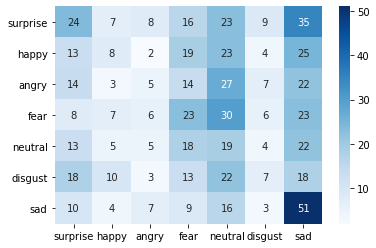

In [9]:
model_linearsvc.display_confusion_matrix()

In [10]:
model_nusvc.trainNUSVC()

model_nusvc.predict()

model_nusvc.model_score()
model_nusvc.accuracy_score

0.16569767441860464

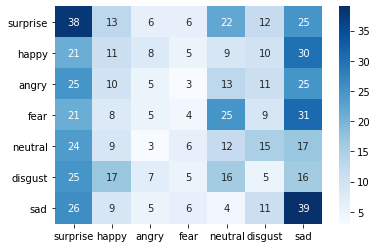

In [11]:
model_nusvc.display_confusion_matrix()

In [12]:
model_svc.trainSVC()

model_svc.predict()

model_svc.model_score()
model_svc.accuracy_score

0.125

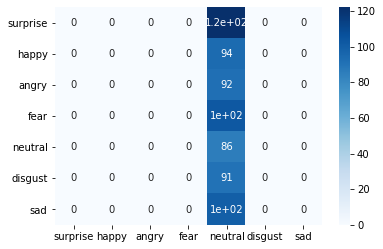

In [13]:
model_svc.display_confusion_matrix()

In [ ]:
model_cnn.my_trainCNN(num_epochs=50, batch_size=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [15]:
model_cnn.CNNlivepredict(feature_extractor)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
model.model_score()
model.accuracy_score

In [ ]:
model.display_confusion_matrix()

In [ ]:
for img_processor in feature_extractor.get_img_processors():
    print(img_processor.name)
    print(img_processor.get_img_shape())